In [1]:
import proposal as pp
import numpy as np
from tqdm import tqdm
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
from helper_functions_multi import get_angle_deviation
import os

In [2]:
data_dir = 'data/run_proposal/'
os.system('mkdir -p {}'.format(data_dir))

plot_dir = 'plots/run_proposal/'
os.system('mkdir -p {}'.format(plot_dir))

save_plot = True

In [13]:
E_i = 1e3
E_f = 200 
n_events = 1000 
    
deflection = [
    'bremsginneken', # 'bremstsaiapproximation', 
    'ioniznaive',
    'photoginneken', # 'photoborogpetrukhin',
    'epairginneken'] ### same as default
    
e_cut = 500 # np.inf 
v_cut = 0.1 # 1e-5
cont_rand = True
scattering_method = "moliere" # "highland"
# deflection_type = "m_scat+stochastic"
  
table_path = "/Users/pgutjahr/.cache/PROPOSAL" # macbook pro
# table_path = "/net/nfshome/home/pgutjahr/.cache/PROPOSAL" # vollmond
    
rnd_seed = 71530

interpol_nodes = 100 # 200

initial_direction = [0, 0, 1]

beta_brems = 1.0
beta_ioniz = 1.0
beta_epair = 1.0
beta_multiplescatter = 1.0
beta_photonuclear = 1.0

max_dist = 1e2 # in cm

In [14]:
pp.InterpolationSettings.tables_path = table_path   # version 7
    
pp.InterpolationSettings.nodes_dndx_e = interpol_nodes
pp.InterpolationSettings.nodes_dndx_v = interpol_nodes

pp.RandomGenerator.get().set_seed(rnd_seed)
args = {
        "particle_def": pp.particle.MuMinusDef(),
        "target": pp.medium.Ice(),
        "interpolate": True,
        "cuts": pp.EnergyCutSettings(e_cut, v_cut, cont_rand)
        }

In [15]:
cross = pp.crosssection.make_std_crosssection(**args)


[2023-06-21 16:43:38.151] [TableCreation] [warning] Tables are not available and need to be created. They will be written to '/Users/pgutjahr/.cache/PROPOSAL'. This can take some minutes.


In [16]:
multiple_scatter = pp.make_multiple_scattering(scattering_method, args["particle_def"], args["target"], cross, True)
stochastic_deflect = []
for d in deflection:
    stochastic_deflect.append(pp.make_stochastic_deflection(d, 
    args["particle_def"], args["target"]))



In [17]:
collection = pp.PropagationUtilityCollection()
collection.displacement = pp.make_displacement(cross, True)
collection.interaction = pp.make_interaction(cross, True)
collection.time = pp.make_time(cross, args["particle_def"], True)
collection.decay = pp.make_decay(cross, args["particle_def"], True)

In [18]:
collection.scattering = pp.scattering.ScatteringMultiplier(
    multiple_scatter, 
    stochastic_deflect, 
    beta_multiplescatter, 
    [(pp.particle.Interaction_Type.brems, beta_brems), (pp.particle.Interaction_Type.ioniz, beta_ioniz), 
    (pp.particle.Interaction_Type.epair, beta_epair), (pp.particle.Interaction_Type.photonuclear, beta_photonuclear)])

utility = pp.PropagationUtility(collection = collection)
detector = pp.geometry.Sphere(pp.Cartesian3D(0,0,0), 1e20) # version 7
density_distr = pp.density_distribution.density_homogeneous(args["target"].mass_density)


prop = pp.Propagator(args["particle_def"], [(detector, utility, density_distr)])

init_state = pp.particle.ParticleState()
init_state.position = pp.Cartesian3D(0, 0, 0) # version 7
init_state.direction = pp.Cartesian3D(initial_direction[0], initial_direction[1], initial_direction[2]) # version 7

# Run simulation

In [19]:
tracks = []
for i in tqdm(range(n_events)):
    init_state.energy = E_i # initial energy in MeV
    track = prop.propagate(init_state, max_distance = max_dist, min_energy = E_f) # max_dist=1e9
    tracks.append(track)

100%|██████████| 1000/1000 [00:00<00:00, 42053.64it/s]


In [20]:
tracks_zenith = []
tracks_azimuth = []
tracks_x = []
tracks_y = []
tracks_z = []
tracks_pos_x = []
tracks_pos_y = []
tracks_pos_z = []
for track in tqdm(tracks):
    tracks_zenith.append(track.track_directions()[-1].spherical_coordinates[2])
    tracks_azimuth.append(track.track_directions()[-1].spherical_coordinates[1])
    tracks_x.append(track.track_directions()[-1].x)
    tracks_y.append(track.track_directions()[-1].y)
    tracks_z.append(track.track_directions()[-1].z)
    tracks_pos_x.append(track.track_positions()[-1].x)
    tracks_pos_y.append(track.track_positions()[-1].y)
    tracks_pos_z.append(track.track_positions()[-1].z)

100%|██████████| 1000/1000 [00:00<00:00, 58775.86it/s]


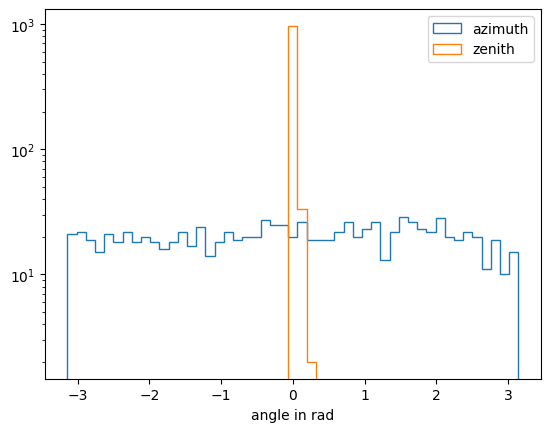

In [21]:
bins = np.linspace(-np.pi, np.pi, 50)
plt.hist(tracks_azimuth, bins=bins, histtype='step', label='azimuth')
plt.hist(tracks_zenith, bins=bins, histtype='step', label='zenith')
plt.xlabel('angle in rad')
plt.yscale('log')
plt.legend()

20.0

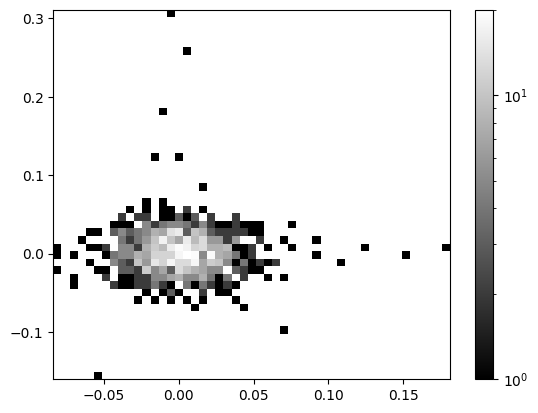

In [22]:
bins = (np.linspace(min(tracks_x), max(tracks_x), 50), np.linspace(min(tracks_y), max(tracks_y), 50))
n = plt.hist2d(tracks_x, tracks_y, bins=bins, norm=mpl.colors.LogNorm(), cmap=mpl.cm.gray)
plt.colorbar()
np.max(n[0])

## save data

In [ ]:
# '''
df = pd.DataFrame()
df['tracks_x'] = tracks_x
df['tracks_y'] = tracks_y
df['tracks_z'] = tracks_z
df['tracks_pos_x'] = tracks_pos_x
df['tracks_pos_y'] = tracks_pos_y
df['tracks_pos_z'] = tracks_pos_z
df['tracks_zenith'] = tracks_zenith
df['tracks_azimuth'] = tracks_azimuth
key = 'E{}_{}_v_cut{}'.format(int(E_i), scattering_method, v_cut)
df.to_hdf(data_dir + 'test.hdf5', key=key)
print(key)
# '''

## read data

In [ ]:
key_0 = 'E1000_moliere_v_cut0.001'
df_0 = pd.read_hdf(data_dir + 'test.hdf5', key=key_0)
df_0

# Plot all 